<a href="https://colab.research.google.com/github/sarthakkaushik/Cdiscount-Image-Classification/blob/main/Cdiscount_project_V1_SK_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Tue Jan 11 06:00:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'

In [5]:
import os 
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'
os.chdir(data_path)
print(os.getcwd())

/gdrive/MyDrive/UOH Assignment Dataset/cdiscount


In [6]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../cdiscount"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

categories.csv
category_names.csv
CheckPoints
file.h5
helper.py
helper.py.1
__pycache__
sample_submission.csv
Tensorboard
test.bson
train.bson
train_example.bson
train_images.csv
train_offsets.csv
train_TFrecords.tfrecords
val_images.csv



In [7]:
data_dir = "../cdiscount/"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

# Create lookup tables

In [8]:
#The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

#You only need to generate these tables once, as they get saved to CSV files.

#Lookup table for categories
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

# categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [15]:
#Create dictionaries for quick lookup of category_id to category_idx mapping.
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    i=0
    for ir in categories_df.itertuples():
            
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
      
    return cat2idx, idx2cat

In [16]:

cat2idx, idx2cat = make_category_tables()

In [17]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(4, 1000012755)

In [12]:
#this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [ ]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

In [ ]:
train_offsets_df.columns

In [ ]:
train_offsets_df.head()

In [ ]:
train_offsets_df['category_id'].value_counts()

In [ ]:
train_offsets_df['num_imgs'].value_counts()

In [ ]:
train_offsets_df.to_csv("train_offsets.csv")

##Create a random train/validation split
We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [18]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

In [19]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, 
                                              drop_percentage=0.9)

NameError: ignored

In [ ]:
train_images_df.head()

In [ ]:
val_images_df.head()

In [ ]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

In [ ]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

In [ ]:
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

##Part 2: The generator

In [20]:
#First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [21]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from PIL import Image

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            #img = load_img(io.BytesIO(bson_img), target_size=self.target_size)
            #print(type(bson_img))
            #img  = load_img(bson_img, target_size =self.target_size)
            # Converting Keras Preprocessing Image load to Pillow Based loading
            # After loading convert to RGB optional as PIL loads in default RGGB
            # And resize is a necessary operation - to self.target_size
            
            img = Image.open(io.BytesIO(bson_img))
            img = img.convert('RGB')
            img = img.resize(self.target_size, Image.NEAREST)
            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [22]:
train_bson_file = open(train_bson_path, "rb")

#Create a generator for training and a generator for validation.

In [23]:
#Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.
import threading
lock = threading.Lock()

In [24]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 989921 images belonging to 5270 classes.
Found 242366 images belonging to 5270 classes.


In [ ]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 705 ms, sys: 131 ms, total: 836 ms
Wall time: 2min 10s


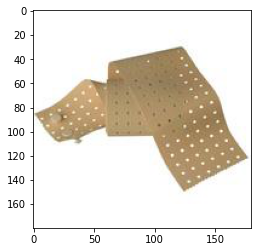

In [ ]:
plt.imshow(bx[-1].astype(np.uint8))

category_level1                MATERIEL MEDICAL
category_level2    KINESITHERAPIE - REEDUCATION
category_level3              ELECTRODE - SANGLE
category_idx                               3741
Name: 1000011711, dtype: object
category_level1    BIJOUX -  LUNETTES - MONTRES
category_level2                        LUNETTES
category_level3              LUNETTES DE SOLEIL
category_idx                               1072
Name: 1000010151, dtype: object


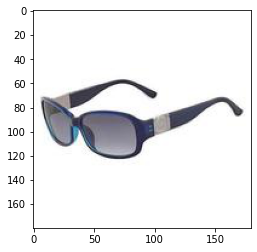

In [ ]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
print(categories_df.loc[cat_id])

bx, by = next(val_gen)

plt.imshow(bx[-1].astype(np.uint8))

cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
print(categories_df.loc[cat_id])

In [25]:
#Importing packages
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,Dense, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing

In [26]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py

# Import helper functions we're going to use
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-01-11 06:02:15--  https://raw.githubusercontent.com/sarthakkaushik/Cdiscount-Image-Classification/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10510 (10K) [text/plain]
Saving to: ‘helper.py.2’

helper.py.2         100%[===================>]  10.26K  --.-KB/s    in 0.003s  

2022-01-11 06:02:15 (3.36 MB/s) - ‘helper.py.2’ saved [10510/10510]



In [27]:
#Define callbacks

import datetime


dir_name = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard'
def create_tensorboard_callback(experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Setup checkpoint path
# checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt' # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

#Model-1

In [ ]:
###------------------------Base Model----------------------------------###

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable =False

#Setup Model architecture

inputs= layers.Input(shape=(180,180,3), name="input_layers")
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_layers")(x)
outputs=layers.Dense(num_classes, activation="softmax", name="output_layers")(x)
model=tf.keras.Model(inputs,outputs)


In [ ]:
#Getting the summary of the model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D_laye  (None, 1280)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layers (Dense)       (None, 5270)              6750870   
                                                                 
Total params: 10,800,441
Trainable params: 6,750,870
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

#Fit the model

model.fit(train_gen,
                    steps_per_epoch = 10,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = 10,  #num_val_images // batch_size,
                    workers = 8)

Epoch 1/3
10/10 [==============================] - 628s 19s/step - loss: 8.2958 - accuracy: 0.0258 - val_loss: 7.9056 - val_accuracy: 0.0758
Epoch 2/3
10/10 [==============================] - 70s 4s/step - loss: 7.5471 - accuracy: 0.1156 - val_loss: 7.1722 - val_accuracy: 0.1211
Epoch 3/3
10/10 [==============================] - 51s 4s/step - loss: 6.9738 - accuracy: 0.1375 - val_loss: 6.7788 - val_accuracy: 0.1500


#Model-2

In [40]:
###------------------------Model-2----------------------------------###
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint_ResNet50.ckpt'


tf.keras.applications.resnet50.ResNet50(
    include_top=False)

base_model_res20=tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model_res20.trainable =False

#Setup Model architecture

inputs= layers.Input(shape=(180,180,3), name="input_layers")
x=base_model_res20(inputs,training=False)
x=layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_layers")(x)
outputs=layers.Dense(num_classes, activation="softmax", name="output_layers")(x)
model_2=tf.keras.Model(inputs,outputs)


In [41]:
#Getting the summary of the model we created
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 GlobalAveragePooling2D_laye  (None, 2048)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layers (Dense)       (None, 5270)              10798230  
                                                                 
Total params: 34,385,942
Trainable params: 10,798,230
Non-trainable params: 23,587,712
_________________________________________________________________


In [43]:
#Compile the model
model_2.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

#Fit the model

history_2=model_2.fit(
    train_gen,
    steps_per_epoch=np.ceil(float(num_train_images) // float(batch_size)),   #num_train_images // batch_size,
    epochs = 3,
    validation_data = val_gen,
    validation_steps=np.ceil(0.25*(float(num_train_images) // float(batch_size))),  #25% of #num_val_images // batch_size,
    callbacks=[checkpoint_callback,create_tensorboard_callback("TranferLearning_ResNet50")],    
    verbose=2                
    # workers = 4
    )

Saving TensorBoard log files to: /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/Tensorboard/TranferLearning_ResNet50/20220111-133822


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3

Epoch 00001: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3931s - loss: 4.0268 - accuracy: 0.3882 - val_loss: 3.8485 - val_accuracy: 0.4231 - 3931s/epoch - 508ms/step
Epoch 2/3

Epoch 00002: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3261s - loss: 2.9469 - accuracy: 0.4755 - 3261s/epoch - 422ms/step
Epoch 3/3

Epoch 00003: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3222s - loss: 2.5416 - accuracy: 0.5175 - 3222s/epoch - 417ms/step


In [46]:
# Evaluate on the test data
results_histor_2 = model_2.evaluate(val_gen)
results_histor_2

1894/1894 [==============================] - 679s 359ms/step - loss: 4.0856 - accuracy: 0.4414


[4.085598945617676, 0.4413779079914093]

#Model-3

In [28]:
###------------------------Base Model----------------------------------
checkpoint_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt'

base_model=tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable =False

#Setup Model architecture

inputs= layers.Input(shape=(180,180,3), name="input_layers")
x=base_model(inputs,training=False)
print(f"Shape after base_model: {x.shape}")
x=layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_layers")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")
outputs=layers.Dense(num_classes, activation="softmax", name="output_layers")(x)
model=tf.keras.Model(inputs,outputs)


#Getting the summary of the model we created
model.summary()

#Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

#Fit the model

history_3=model.fit(
    train_gen,
    steps_per_epoch=np.ceil(float(num_train_images) // float(batch_size)),   #num_train_images // batch_size,
    epochs = 6,
    validation_data = val_gen,
    validation_steps=np.ceil(0.25*(float(num_train_images) // float(batch_size))),  #25% of #num_val_images // batch_size,
    callbacks=[checkpoint_callback,create_tensorboard_callback("TranferLearning_EfficientNetB7")],    
    verbose=2                
    # workers = 4
    )




Shape after base_model: (None, 5, 5, 2560)
After GlobalAveragePooling2D(): (None, 2560)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 GlobalAveragePooling2D_laye  (None, 2560)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layers (Dense)       (None, 5270)              13496470  
                                                                 
Total params: 77,594,157
Trainable params: 13,496,470
Non-trainable params: 64,097,687
_________________________________________________________________
Saving TensorBoard

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/6

Epoch 00001: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 5846s - loss: 3.3010 - accuracy: 0.4236 - val_loss: 3.0035 - val_accuracy: 0.4609 - 5846s/epoch - 756ms/step
Epoch 2/6

Epoch 00002: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3874s - loss: 2.4506 - accuracy: 0.5103 - 3874s/epoch - 501ms/step
Epoch 3/6

Epoch 00003: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3874s - loss: 2.1224 - accuracy: 0.5538 - 3874s/epoch - 501ms/step
Epoch 4/6

Epoch 00004: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3876s - loss: 1.9119 - accuracy: 0.5847 - 3876s/epoch - 501ms/step
Epoch 5/6

Epoch 00005: saving model to /gdrive/MyDrive/UOH Assignment Dataset/cdiscount/CheckPoints/checkpoint.ckpt
7733/7733 - 3876s - loss: 1.7557 - accuracy: 0.6096 - 387

In [29]:
# Evaluate on the test data
results_histor_3 = model.evaluate(val_gen)
results_histor_3

1894/1894 [==============================] - 956s 505ms/step - loss: 3.0152 - accuracy: 0.4965


NameError: ignored

In [30]:
results_histor_3

[3.015165328979492, 0.496476411819458]

ValueError: ignored

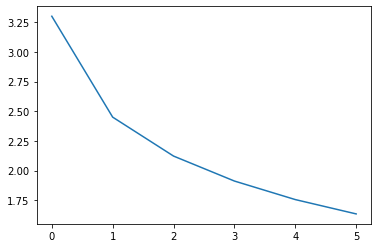

In [31]:
# Plot model loss curves
plot_loss_curves(history_3)